In [ ]:
import nbformat

# Path to this notebook in Colab
notebook_path = '/content/drive/MyDrive/Colab Notebooks/comparativeAnalysis.ipynb'

# Load the current notebook
with open('/content/drive/MyDrive/Colab Notebooks/comparativeAnalysis.ipynb', 'r') as f:
    nb = nbformat.read(f, as_version=nbformat.NO_CONVERT)

# Remove problematic widget metadata
if 'widgets' in nb.metadata:
    del nb.metadata['widgets']

# Save cleaned version
with open(notebook_path, 'w') as f:
    nbformat.write(nb, f)

print(f"Cleaned notebook saved to {notebook_path}")


Cleaned notebook saved to /content/drive/MyDrive/Colab Notebooks/comparativeAnalysis.ipynb


In [ ]:
!git clone https://github.com/RaphaelEse/LawGorithmML.git

Cloning into 'LawGorithmML'...
remote: Enumerating objects: 853, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 853 (delta 49), reused 121 (delta 18), pack-reused 676 (from 1)
Receiving objects: 100% (853/853), 56.21 MiB | 6.67 MiB/s, done.
Resolving deltas: 100% (388/388), done.
Updating files: 100% (785/785), done.


In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00


In [3]:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_save_path = "/content/drive/My Drive/legal_nlp_artifacts"
os.makedirs(drive_save_path, exist_ok=True)


In [4]:
# Install PyTorch Geometric and dependencies
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 32.4 MB/s eta 0:00:00


In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch
from datasets import Dataset
import os
import glob
import pandas as pd
import json
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
import concurrent.futures
from sklearn.utils import resample
import nltk
from nltk.tokenize import sent_tokenize
from concurrent.futures import ThreadPoolExecutor
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from torch_geometric.data import Data
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Module
from torch import optim
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


In [6]:
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Define the path to the full-text bills
bills_path = "/content/LawGorithmML/citations/citations/sample_bills"

# Get all text files in the directory
bill_files = sorted(glob.glob(os.path.join(bills_path, "*.txt")))

bill_texts = {}
def load_file(file):
    with open(file, "r", encoding="utf-8") as f:
        return os.path.basename(file), f.read()

# Load 108 bills using multi-threading
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(load_file, bill_files)

bill_texts = dict(results)

print(f"Loaded {len(bill_texts)} bills.")

Loaded 108 bills.


In [ ]:
json_path = "/content/LawGorithmML/labeled_citations_zero_shot/"
# Get all JSON files in the directory
# Load cleaned citation JSON files
json_files = sorted(os.listdir(json_path))

# Read and combine JSON files
cleaned_citations = []
for file in json_files:
    with open(os.path.join(json_path, file), "r", encoding="utf-8") as f:
        cleaned_citations.extend(json.load(f))

# Convert to DataFrame
df_citations = pd.DataFrame(cleaned_citations)

df_citations["normCite"] = df_citations["normCite"].astype(str)

# Filter out citations without `normCite`
df_citations = df_citations[df_citations["normCite"].notna()]
df_citations = df_citations[df_citations["normCite"].str.strip() != ""]
# Display dataset size
print(f"Loaded {len(json_files)} cleaned citation files with {len(df_citations)} citations.")
df_citations.head()


Loaded 77 cleaned citation files with 17405 citations.


,text,startPosition,endPosition,normCite,citeType,altCite,pinCiteStr,pageRangeStr,nodeId,section,sectionAndSubSection,isShortCite,chunk_id,high_confidence
13,Sec. 604,6331,6339,33 usc 1384,USC,33 usc 1384,,,0,,,True,0.0,Precedent
31,Sec. 104,9376,9384,42 usc 5304,USC,42 usc 5304,,,0,,,True,0.0,Amendment
32,Sec. 105,9480,9488,42 usc 5305,USC,42 usc 5305,,,0,,,True,0.0,Example
44,Sec. 204,10663,10671,7 usc 7508,USC,7 usc 7508,,,0,,,True,0.0,Amendment
48,Sec. 211,11303,11311,34 usc 60531,USC,34 usc 60531,,,0,,,True,0.0,Amendment


In [ ]:
# Count occurrences of each string label
print(df_citations["high_confidence"].value_counts())

high_confidence
Example       6612
Amendment     3962
Precedent     2556
Authority     1651
Exception     1425
Definition    1199
Name: count, dtype: int64


In [ ]:
df_citations = pd.read_csv("/content/drive/MyDrive/legal_nlp_artifacts/extracted_contexts.csv")
df_citations = df_citations.dropna(subset=["context", "high_confidence"])
df_citations.head()

,text,startPosition,endPosition,normCite,citeType,altCite,pinCiteStr,pageRangeStr,nodeId,section,sectionAndSubSection,isShortCite,chunk_id,high_confidence,context
0,section 101(9),28956,28970,38 usc 101,USC,38 U.S.C. § 101(9),NaN,NaN,0,NaN,NaN,True,0.0,Amendment,REFERENCES Except as expressly provided otherw...
1,section 101,30092,30103,38 usc 101,USC,38 U.S.C. § 101,NaN,NaN,0,NaN,NaN,True,0.0,Example,REFERENCES Except as expressly provided otherw...
2,section 101,30411,30422,38 usc 101,USC,38 U.S.C. § 101,NaN,NaN,0,NaN,NaN,True,0.0,Exception,REFERENCES Except as expressly provided otherw...
3,section 101,30945,30956,38 usc 101,USC,38 U.S.C. § 101,NaN,NaN,0,NaN,NaN,True,0.0,Example,REFERENCES Except as expressly provided otherw...
4,section 101,31203,31214,38 usc 101,USC,38 U.S.C. § 101,NaN,NaN,0,NaN,NaN,True,0.0,Definition,REFERENCES Except as expressly provided otherw...


In [ ]:
bill_sentences = {
    name: sent_tokenize(text)
    for name, text in bill_texts.items()
}

def extract_context(row):
    #Extracts context from a bill given a citation
    citation_text = row["text"]

    for bill_name, sentences in bill_sentences.items():
        for i, sentence in enumerate(sentences):
            if citation_text in sentence:
                start = max(0, i - 2)
                end = i + 1  # Only before and including citation sentence
                selected = " ".join(sentences[start:end]).strip()
                selected = re.sub(r"\s+", " ", selected)  # Clean up spaces
                return selected if len(selected) > 20 else None
    return None

# Convert to list for parallel processing
rows = df_citations.to_dict(orient="records")


with ThreadPoolExecutor() as executor:
    contexts = list(executor.map(extract_context, rows))

# Assign back to DataFrame
df_citations["context"] = contexts

# Drop rows with no context
df_citations = df_citations.dropna(subset=["context"])

# View result
df_citations[["text", "context"]].head()


,text,context
113,section 101(9),REFERENCES Except as expressly provided otherw...
120,section 101,REFERENCES Except as expressly provided otherw...
121,section 101,REFERENCES Except as expressly provided otherw...
123,section 101,REFERENCES Except as expressly provided otherw...
124,section 101,REFERENCES Except as expressly provided otherw...


In [ ]:
# View result
df_citations[["text", "context"]].head(10)

,text,context
113,section 101(9),REFERENCES Except as expressly provided otherw...
120,section 101,REFERENCES Except as expressly provided otherw...
121,section 101,REFERENCES Except as expressly provided otherw...
123,section 101,REFERENCES Except as expressly provided otherw...
124,section 101,REFERENCES Except as expressly provided otherw...
125,section 101,REFERENCES Except as expressly provided otherw...
126,section 251(b)(2)(A)(i) of the Balanced Budget...,Amounts made available by section 101 for Depa...
128,section 101,REFERENCES Except as expressly provided otherw...
130,section 101,REFERENCES Except as expressly provided otherw...
132,section 101,REFERENCES Except as expressly provided otherw...


In [ ]:
# Keep only necessary columns
df = df_citations[["text", "normCite", "citeType", "context", "high_confidence"]]

# Rename columns for clarity
df = df.rename(columns={"high_confidence": "label"})

# Encode labels as numbers (since models need numerical labels)
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

# Save label mapping for later decoding
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Split into train/test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["context"], df["label"], test_size=0.2, random_state=42
)

# Convert into Pandas DataFrame format
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})

# Ensure training and test dataframes have contexts and labels
print(f"Training Samples: {len(train_df)}, Test Samples: {len(test_df)}")
train_df.head(10)

Label Mapping: {'Amendment': np.int64(0), 'Authority': np.int64(1), 'Definition': np.int64(2), 'Example': np.int64(3), 'Exception': np.int64(4), 'Precedent': np.int64(5)}
Training Samples: 7588, Test Samples: 1898


,text,label
3405,"9011)), cotton, and sugar; and (ii) shall not ...",3
7841,"9011)), cotton, and sugar; and (ii) shall not ...",2
7608,BANNING OF PRODUCTS CONTAINING A HIGH CONCENTR...,3
533,Domestic Food Programs Food and Nutrition Serv...,1
473,Domestic Food Programs Food and Nutrition Serv...,2
8435,"9011)), cotton, and sugar; and (ii) shall not ...",0
3905,"9011)), cotton, and sugar; and (ii) shall not ...",5
2728,Domestic Food Programs Food and Nutrition Serv...,3
65,Amounts made available by section 101 for Depa...,5
2375,BANNING OF PRODUCTS CONTAINING A HIGH CONCENTR...,5


In [ ]:
# LegalBERT
MODEL_NAME = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Convert Pandas DF to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize dataset
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Load pre-trained model for classification
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_encoder.classes_))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/7588 [00:00<?, ? examples/s]

Map:   0%|          | 0/1898 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" Using device: {device}")

 Using device: cuda


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
model.to(device)
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=30,
    weight_decay=0.05,
    fp16=True,
    logging_dir='./logs',
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)
# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.518101,0.425184,0.321399,0.361588,0.425184
2,No log,1.511408,0.431507,0.339237,0.396970,0.431507
3,1.485000,1.502697,0.435722,0.346856,0.409021,0.435722
4,1.485000,1.511055,0.431507,0.352914,0.384591,0.431507
5,1.454800,1.515994,0.432561,0.351335,0.395536,0.432561
6,1.454800,1.499831,0.436249,0.358616,0.416307,0.436249
7,1.417000,1.501251,0.437829,0.371744,0.431516,0.437829
8,1.417000,1.511987,0.429926,0.372113,0.428139,0.429926
9,1.369900,1.527329,0.440464,0.376223,0.441155,0.440464
10,1.369900,1.522360,0.437302,0.372375,0.435189,0.437302


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Save model and tokenizer
model.save_pretrained("./fine_tuned_legalbert")
tokenizer.save_pretrained("./fine_tuned_legalbert")
# Zip the model folder
!zip -r fine_tuned_legalbert.zip fine_tuned_legalbert

# Download to local computer
from google.colab import files
files.download("fine_tuned_legalbert.zip")


  adding: fine_tuned_legalbert/ (stored 0%)
  adding: fine_tuned_legalbert/model.safetensors (deflated 7%)
  adding: fine_tuned_legalbert/vocab.txt (deflated 51%)
  adding: fine_tuned_legalbert/special_tokens_map.json (deflated 42%)
  adding: fine_tuned_legalbert/tokenizer_config.json (deflated 75%)
  adding: fine_tuned_legalbert/tokenizer.json (deflated 71%)
  adding: fine_tuned_legalbert/config.json (deflated 55%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Retreive and use model
model = AutoModelForSequenceClassification.from_pretrained("./fine_tuned_legalbert")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_legalbert")

In [ ]:
demo_samples = df_citations.sample(5)["context"].tolist()

In [ ]:
lTrain_df = train_df.sample(frac=0.25, random_state=42).reset_index(drop=True)

# Reduce the test set for longformer model
lTest_df = test_df.sample(frac=0.25, random_state=42).reset_index(drop=True)

# Display new sizes
print(f"New training set size: {len(lTrain_df)}")
print(f"New test set size: {len(lTest_df)}")


🔹 New training set size: 3330
🔹 New test set size: 833


In [ ]:
#Longformer
MODEL_NAME = "allenai/longformer-base-4096"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=4096,
        return_tensors="pt"
    )

# Convert Pandas DF to Hugging Face Dataset
train_dataset = Dataset.from_pandas(lTrain_df)
test_dataset = Dataset.from_pandas(lTest_df)

# Tokenize dataset
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Load pre-trained model for classification
lModel = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_encoder.classes_))

Map:   0%|          | 0/3330 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lModel.to(device)
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=7,
    weight_decay=0.05,
    fp16=True,
    logging_dir='./logs',
)

# Trainer
trainer = Trainer(
    model=lModel,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)
# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.576200,1.561742,0.441777,0.328123,0.285628,0.441777
2,1.555900,1.540927,0.445378,0.334423,0.289112,0.445378


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Save model and tokenizer
lModel.save_pretrained("./fine_tuned_longformer")
tokenizer.save_pretrained("./fine_tuned_longformer")
# Download to local computer
from google.colab import files
files.download("fine_tuned_longformer.zip")

In [7]:
train_df = pd.read_csv("/content/drive/MyDrive/legal_nlp_artifacts/train_dataset.csv")
test_df = pd.read_csv("/content/drive/MyDrive/legal_nlp_artifacts/test_dataset.csv")
df = pd.concat([train_df, test_df], ignore_index=True).reset_index(drop=True)
balanced_sample = df.groupby("original_label").sample(n=3000, random_state=42)

In [8]:
# Generate TF-IDF matrix for context text
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(balanced_sample["context"])

# Compute cosine similarity between contexts
similarity_matrix = cosine_similarity(X_tfidf)

# Build a graph: nodes = context rows, edges = similarity > threshold
threshold = 0.5
adj_matrix = (similarity_matrix > threshold).astype(int)

# Create NetworkX graph
G = nx.from_numpy_array(adj_matrix)

In [9]:
features = X_tfidf.toarray()
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(balanced_sample["original_label"])

In [10]:
# Convert to PyTorch tensors
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)
edge_index = torch.tensor(np.array(G.edges).T, dtype=torch.long)

# Create graph object
data = Data(x=x, edge_index=edge_index, y=y)

In [11]:
class GCN(Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [12]:
# Convert to PyTorch tensors
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)
edge_index = torch.tensor(np.array(G.edges).T, dtype=torch.long)

# Create data object
data = Data(x=x, edge_index=edge_index, y=y,
            bill=torch.tensor(balanced_sample["bill"].astype("category").cat.codes.values),
    citation_id=torch.tensor(balanced_sample["citation_id"].astype("category").cat.codes.values))

# Split data into 80% train, 20% test
num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
train_size = int(num_nodes * 0.8)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[perm[:train_size]] = True

data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[perm[train_size:]] = True

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gModel = GCN(in_channels=x.shape[1], hidden_channels=64, out_channels=len(np.unique(labels))).to(device)
data = data.to(device)
optimizer = optim.Adam(gModel.parameters(), lr=0.01, weight_decay=5e-4)

# Initialize list to track metrics
metrics_per_epoch = []

# Training loop
for epoch in range(1, 201):
    gModel.train()
    optimizer.zero_grad()
    out = gModel(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Evaluation every 10 epochs
    if epoch % 10 == 0 or epoch == 1:
        gModel.eval()
        out = gModel(data)
        _, pred = out.max(dim=1)

        # Extract predictions and true labels
        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()

        # Compute metrics
        acc = accuracy_score(y_true, y_pred)
        f1_weighted = f1_score(y_true, y_pred, average="weighted")
        f1 = f1_score(y_true, y_pred, average="micro")
        precision = precision_score(y_true, y_pred, average="weighted")
        recall = recall_score(y_true, y_pred, average="weighted")

        # Print checkpoint metrics
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Accuracy: {acc:.4f} | F1: {f1:.4f} | Weighted F1: {f1_weighted:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}" )

        # Save to list
        metrics_per_epoch.append({
            "Epoch": epoch,
            "Accuracy": acc,
            "F1": f1,
            "Weighted F1": f1_weighted,
            "Precision": precision,
            "Recall": recall
        })

# Convert results to DataFrame
metrics_df = pd.DataFrame(metrics_per_epoch)
metrics_df.to_csv("/content/drive/MyDrive/legal_nlp_artifacts/gcn_epoch_metrics.csv", index=False)

Epoch 001 | Loss: 1.6149 | Accuracy: 0.5803 | F1: 0.5803 | Weighted F1: 0.5780 | Precision: 0.5919 | Recall: 0.5803
Epoch 010 | Loss: 0.8787 | Accuracy: 0.6877 | F1: 0.6877 | Weighted F1: 0.6893 | Precision: 0.7012 | Recall: 0.6877
Epoch 020 | Loss: 0.6998 | Accuracy: 0.7323 | F1: 0.7323 | Weighted F1: 0.7351 | Precision: 0.7475 | Recall: 0.7323
Epoch 030 | Loss: 0.5997 | Accuracy: 0.7900 | F1: 0.7900 | Weighted F1: 0.7920 | Precision: 0.8022 | Recall: 0.7900
Epoch 040 | Loss: 0.5369 | Accuracy: 0.7977 | F1: 0.7977 | Weighted F1: 0.7976 | Precision: 0.8026 | Recall: 0.7977
Epoch 050 | Loss: 0.4966 | Accuracy: 0.8043 | F1: 0.8043 | Weighted F1: 0.8042 | Precision: 0.8110 | Recall: 0.8043
Epoch 060 | Loss: 0.4713 | Accuracy: 0.8240 | F1: 0.8240 | Weighted F1: 0.8238 | Precision: 0.8277 | Recall: 0.8240
Epoch 070 | Loss: 0.4515 | Accuracy: 0.8200 | F1: 0.8200 | Weighted F1: 0.8199 | Precision: 0.8254 | Recall: 0.8200
Epoch 080 | Loss: 0.4362 | Accuracy: 0.8637 | F1: 0.8637 | Weighted F1: 

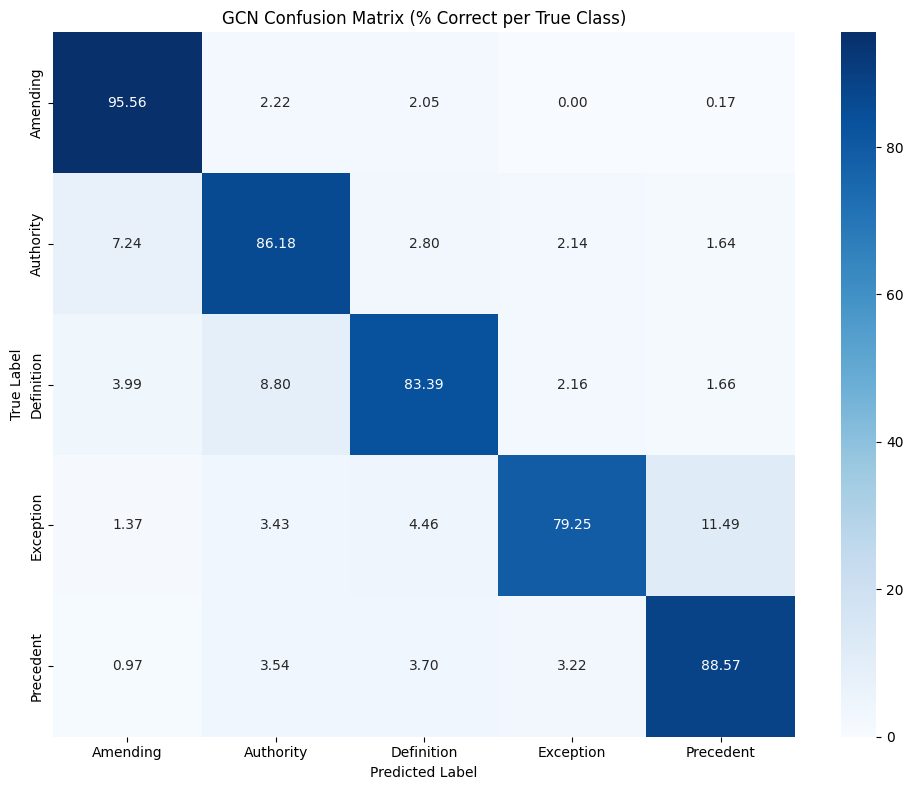

In [15]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert to row-wise percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percent = np.round(cm_percent, 2)

# Manual label names (ordered by label mapping)
labels_text = ['Amending', 'Authority', 'Definition', 'Exception', 'Precedent']

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels_text,
            yticklabels=labels_text)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("GCN Confusion Matrix (% Correct per True Class)")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/legal_nlp_artifacts/gcn_confusion_matrix_percent.png")
plt.show()

In [16]:
# Get predictions
gModel.eval()
out = gModel(data)
_, pred = out.max(dim=1)

# Masked predictions and true labels
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

# Compute all metrics
acc = accuracy_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="micro")
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")

# Print them
print(f"\nFinal Test Accuracy: {acc:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

# Optional: Show full per-class breakdown
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Save to CSV
results = pd.DataFrame([{
    "Accuracy": acc,
    "Weighted F1": f1_weighted,
    "F1": f1,
    "Precision": precision,
    "Recall": recall
}])
results.to_csv("/content/drive/MyDrive/legal_nlp_artifacts/gcn_metrics.csv", index=False)


Final Test Accuracy: 0.8660
Weighted F1 Score: 0.8653
Precision: 0.8673, Recall: 0.8660

Classification Report:
              precision    recall  f1-score   support

    Amending       0.87      0.96      0.91       586
   Authority       0.83      0.86      0.85       608
  Definition       0.87      0.83      0.85       602
   Exception       0.91      0.79      0.85       583
   Precedent       0.86      0.89      0.87       621

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



In [19]:
# Create results DataFrame
results_df = pd.DataFrame({
    "predicted_label": label_encoder.inverse_transform(pred.cpu().numpy()),
    "true_label": label_encoder.inverse_transform(data.y.cpu().numpy()),
    "bill": balanced_sample["bill"].values,
    "citation_id": balanced_sample["citation_id"].values,
    "context": balanced_sample["context"].values
})

filtered_results_df = results_df[
    (results_df["bill"].notna()) &
    (results_df["citation_id"].notna()) &
    (results_df["bill"] != "") &
    (results_df["citation_id"] != "")
]

# Save the filtered results
filtered_results_df.to_csv("/content/drive/MyDrive/legal_nlp_artifacts/gcn_predictions_real.csv", index=False)